# Calcium Group Plotting & Statistics

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
import lvm_read
from tkinter import Tk
from tkinter.filedialog import askdirectory
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import glob
import fnmatch

plt.style.use('seaborn-white')
%matplotlib inline

py.offline.init_notebook_mode(connected=True)

## Selecting the data folder
Should contain all .mat files

In [2]:
root = Tk()
ttl = "Select directory"

if os.name == 'nt':
    dir1 = 'D:\\data'   # Windows
else:
    dir1 = '/Volumes/Zhivaz/'
    
root.withdraw()
file_path = askdirectory(initialdir = dir1, title = ttl)
root.update()
root.destroy()
print('main path :', file_path)


calcium_regressors = []
for folderName, subfolders, filenames in os.walk(file_path):
    for file in filenames:
        if fnmatch.fnmatch(file, '*.mat'):
            calcium_regressors.append(os.path.join(os.path.abspath(folderName),file))

# calcium_regressors = glob.glob(os.path.join(os.path.abspath(file_path),file_ending))
print('.mat files found: ',calcium_regressors)


main path : D:/MRIDATA/Calciumanalysis/LckGRCaMP/3Hz
.mat files found:  ['D:\\MRIDATA\\Calciumanalysis\\LckGRCaMP\\3Hz\\6790_E16\\6790_E16.mat', 'D:\\MRIDATA\\Calciumanalysis\\LckGRCaMP\\3Hz\\6792_E7\\6792_E7.mat', 'D:\\MRIDATA\\Calciumanalysis\\LckGRCaMP\\3Hz\\6793_E8\\6793_E8.mat']


In [3]:
alldata=[]
N_files=len(calcium_regressors)

for i in range(N_files):
    alldata.append(sio.loadmat(calcium_regressors[i]))
    
    
def get_nth_key(dictionary, n=0):
    if n < 0:
        n += len(dictionary)
    for i, key in enumerate(dictionary.keys()):
        if i == n:
            return key
    raise IndexError("dictionary index out of range") 

In [21]:
# N_files
# animallist = alldata[0].keys()
# alldata[0].values()
# animallist
# alldata[0]

# name_channel = get_nth_key(alldata[0],4)

stim_events = alldata[0][os.path.split(calcium_regressors[0])[1][:-4]+' Channel 1']['stim'][0][0][0]

#Create data frames
time_sec=alldata[0][os.path.split(calcium_regressors[0])[1][:-4]+' Channel 1']['time'][0][0][0] # must be same for all files, so read it from first mat file
index = pd.Index(time_sec)
columns = pd.MultiIndex.from_product([['channel1','channel2'],['mean','SD','stim']],names=['channel','datatype'])
# df0 = pd.DataFrame(np.zeros((index.size,columns.size)),index = index, columns = columns)

dfs=[]
measurements=[]
for i in range(N_files):
    measurementname = 'measurement ' + get_nth_key(alldata[i],4)[:-10]
    df = pd.DataFrame(np.zeros((index.size,columns.size)),index = index, columns = columns)
    
    df['channel1','mean'] = alldata[i][get_nth_key(alldata[i],3)]['mean'][0][0][0][0:index.size]

    df['channel1','SD'] = alldata[i][get_nth_key(alldata[i],3)]['SD'][0][0][0][0:index.size]
#     df['channel1','stim'] = alldata[0][get_nth_key(alldata[0],3)]['stim'][0][0][0]
    
    df['channel2','mean'] = alldata[i][get_nth_key(alldata[i],4)]['mean'][0][0][0][0:index.size]
    df['channel2','SD'] = alldata[i][get_nth_key(alldata[i],4)]['SD'][0][0][0][0:index.size]
#     df['channel2','stim'] = alldata[0][get_nth_key(alldata[0],4)]['stim'][0][0][0]
    measurements.append(measurementname)
    dfs.append(df)


dffinal=pd.concat(dfs, axis=1, names=['channel','datatype','scan'], ignore_index=False)

forplotting_mean = dffinal['channel2']['mean'].mean(axis=1)
forplotting_individual = dffinal['channel2']['mean']


(array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64), array([0.02712891, 0.03023227, 0.03333563, 0.03643899, 0.03954235,
       0.04264571, 0.04574907, 0.04885243, 0.05195579, 0.05505915,
       0.05816251]))


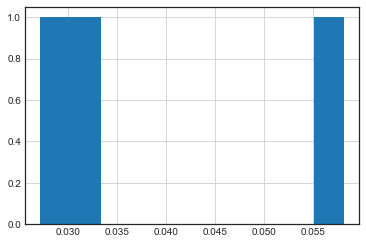

In [19]:
# Optional:  Normalize by baseline standard deviation
if True:
    xx = forplotting_individual.loc[0:10,:].describe()
    xx
    # x = xx.loc['mean',:]/xx.loc['std',:]
    x = xx.loc['std',:]
    x.hist()
    h = np.histogram(x)
    print(h)

    target=0.6  #<-- choose a value here
    k=0
    for i in x:
        factor = target/i
        forplotting_individual.iloc[:,k]=forplotting_individual.iloc[:,k]*factor
        k+=1

    forplotting_mean=forplotting_individual.mean(axis=1)

In [22]:
shapes1 = list()
for i in stim_events:
    shapes1.append({
        'type': 'line',
        'xref': 'x',
        'yref': 'y',
        'x0': i,
        'y0': 0,
        'x1': i,
        'y1': np.max(forplotting_individual.max()),
        'opacity':0.4,
        'layer': 'above',
        'line':{
            'color':'red',
        },
    })


layout1 = go.Layout(
    title='responses',
    yaxis=dict(
    title='%'
    ),
    xaxis=dict(
    title='time [s]'
    ),
     shapes=shapes1
    )
        
traceA=[]
k=1
for i in range(forplotting_individual.columns.size):
    traceA.append(go.Scatter(x=forplotting_individual.index.values, y=forplotting_individual.iloc[:,i].values, mode = 'lines', name = 'recording '+str(k)))
    k += 1
traceA.append(go.Scatter(x=forplotting_mean.index.values, y=forplotting_mean.values, mode = 'lines', line=dict(width=1.2, color='black'), name = 'Mean of All'))
  
    
fig = go.Figure(data=traceA, layout=layout1)
py.offline.iplot(fig)   